In [58]:
import pandas as pd
from river import stream, metrics, evaluate, ensemble, forest, tree
from river.forest import ARFClassifier
import matplotlib.pyplot as plt


# 1. Load the Covertype dataset
covertype = pd.read_csv(
    '/Users/aazab/Partition_A/Master/Poland Master/master/data/covertype/covtype.data',
    header=None
)

X_cov = covertype.iloc[:, :-1]  # features
y_cov = covertype.iloc[:, -1]   # target

In [29]:
# 2. Convert to a stream
cov_stream = stream.iter_pandas(X_cov, y_cov)

In [30]:
# 3. Initialize Adaptive Random Forest
model = ARFClassifier(
    n_models=10,
    max_features=10,
    seed=42,
    leaf_prediction="mc"
)

# 4. Metric
metric = metrics.Accuracy()

In [31]:
# 5. Progressive evaluation
score = evaluate.progressive_val_score(
    dataset=cov_stream,
    model=model,
    metric=metric,
    print_every=10000   # prints intermediate accuracy every 10k samples
)

print("Final accuracy:", score)

[10,000] Accuracy: 73.90%
[20,000] Accuracy: 75.91%
[30,000] Accuracy: 81.03%
[40,000] Accuracy: 83.53%
[50,000] Accuracy: 85.54%
[60,000] Accuracy: 86.88%
[70,000] Accuracy: 87.47%
[80,000] Accuracy: 87.56%
[90,000] Accuracy: 87.96%
[100,000] Accuracy: 88.52%
[110,000] Accuracy: 88.99%
[120,000] Accuracy: 89.28%
[130,000] Accuracy: 89.30%
[140,000] Accuracy: 89.52%
[150,000] Accuracy: 89.46%
[160,000] Accuracy: 89.66%
[170,000] Accuracy: 89.57%
[180,000] Accuracy: 89.65%
[190,000] Accuracy: 89.75%
[200,000] Accuracy: 89.95%
[210,000] Accuracy: 90.14%
[220,000] Accuracy: 90.15%
[230,000] Accuracy: 89.92%
[240,000] Accuracy: 89.67%
[250,000] Accuracy: 89.23%
[260,000] Accuracy: 88.92%
[270,000] Accuracy: 88.59%
[280,000] Accuracy: 88.15%
[290,000] Accuracy: 87.71%
[300,000] Accuracy: 87.53%
[310,000] Accuracy: 87.49%
[320,000] Accuracy: 87.27%
[330,000] Accuracy: 87.12%
[340,000] Accuracy: 86.89%
[350,000] Accuracy: 86.59%
[360,000] Accuracy: 86.38%
[370,000] Accuracy: 86.20%
[380,000] 

Running Loss for Classification Streams

We’ll define loss as 0 if prediction correct, 1 if wrong.
Then we compute the cumulative running average:

![CleanShot 2025-09-24 at 09.46.59@2x.png](<attachment:CleanShot 2025-09-24 at 09.46.59@2x.png>)
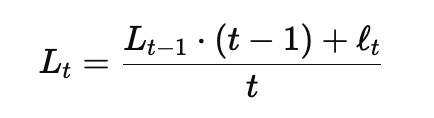

Where:

lt = nstantaneous loss at time t
Lt = running average loss after t samples


In [39]:
ARFmodel = ARFClassifier(
    n_models=10,
    max_features=10,
    seed=42,
    leaf_prediction="mc"
)

metric = metrics.Accuracy()

In [ ]:
# def test_then_train(model, data_stream, metric, n=10000):
#     for i, (x, y) in enumerate(data_stream, start=1):
#         # Test
#         y_pred = model.predict_one(x)
#         metric = metric.update(y, y_pred)

#         # Train
#         model = model.learn_one(x, y)

#         if i % 2000 == 0:
#             print(f"Seen {i} samples – Accuracy: {metric.get():.4f}")
        
#         if i > n:  # limit for demo
#             break
#     return metric

# print("CoverType with ARF:")
# test_then_train(ARFmodel, cov_stream, metrics.Accuracy())


In [ ]:
def test_then_train_running_loss(model, dataStream, n=10000):
    running_losses = []   # average running loss over time
    instant_losses = []   # 0-1 loss at each step
    y_preds = []          # predictions
    y_true = []           # ground-truth labels

    avg_loss = 0.0

    for i, (x, y) in enumerate(dataStream, start=1):
        # ---------- TEST ----------
        y_hat = model.predict_one(x)

        # Save prediction
        y_preds.append(y_hat)
        y_true.append(y)

        # Instantaneous 0-1 loss
        loss_t = 0 if y_hat == y else 1
        instant_losses.append(loss_t)

        # Update running average loss
        avg_loss = ((avg_loss * (i - 1)) + loss_t) / i
        running_losses.append(avg_loss)

        #TODO: apply drift detection here
        #TODO: if drift detected, reset the model
        #TODO: ------------------------------------
        # ---------- TRAIN ----------
        model.learn_one(x, y)

        if i % 2000 == 0:
            print(f"Seen {i} samples – Running loss: {avg_loss:.4f}")

        if i >= n:
            break

    return {
        "running_losses": running_losses,
        "instant_losses": instant_losses,
        "y_preds": y_preds,
        "y_true": y_true
    }

In [50]:
ARFmodel = ARFClassifier(
    n_models=10,
    max_features=10,
    seed=42,
    leaf_prediction="mc"
)

metric = metrics.Accuracy()

cov_stream = stream.iter_pandas(X_cov, y_cov)

loss_dict = test_then_train_running_loss(ARFmodel, cov_stream, n=500000)

Seen 2000 samples – Running loss: 0.3085
Seen 4000 samples – Running loss: 0.2657
Seen 6000 samples – Running loss: 0.2572
Seen 8000 samples – Running loss: 0.2666
Seen 10000 samples – Running loss: 0.2611
Seen 12000 samples – Running loss: 0.2652
Seen 14000 samples – Running loss: 0.2785
Seen 16000 samples – Running loss: 0.2732
Seen 18000 samples – Running loss: 0.2570
Seen 20000 samples – Running loss: 0.2409
Seen 22000 samples – Running loss: 0.2245
Seen 24000 samples – Running loss: 0.2119
Seen 26000 samples – Running loss: 0.2028
Seen 28000 samples – Running loss: 0.1953
Seen 30000 samples – Running loss: 0.1897
Seen 32000 samples – Running loss: 0.1854
Seen 34000 samples – Running loss: 0.1832
Seen 36000 samples – Running loss: 0.1789
Seen 38000 samples – Running loss: 0.1726
Seen 40000 samples – Running loss: 0.1647
Seen 42000 samples – Running loss: 0.1586
Seen 44000 samples – Running loss: 0.1542
Seen 46000 samples – Running loss: 0.1522
Seen 48000 samples – Running loss: 0.1

In [51]:
print("Keys returned:", loss_dict.keys())
print("Final running loss:", loss_dict["running_losses"][-1])

Keys returned: dict_keys(['running_losses', 'instant_losses', 'y_preds', 'y_true'])
Final running loss: 0.14302399999999924


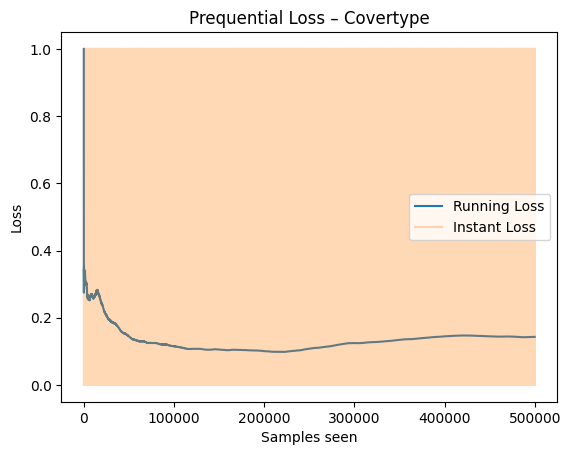

In [52]:
import matplotlib.pyplot as plt

plt.plot(loss_dict["running_losses"], label="Running Loss")
plt.plot(loss_dict["instant_losses"], alpha=0.3, label="Instant Loss")
plt.legend()
plt.xlabel("Samples seen")
plt.ylabel("Loss")
plt.title("Prequential Loss – Covertype")
plt.show()


In [60]:
ht = tree.HoeffdingTreeClassifier()

models = {
    "Bagging": ensemble.BaggingClassifier(model=ht, n_models=10, seed=42),
    "LeveragingBagging": ensemble.LeveragingBaggingClassifier(model=ht, n_models=10, seed=42),
    "ADWINBagging": ensemble.ADWINBaggingClassifier(model=ht, n_models=10, seed=42),
    "AdaBoost": ensemble.AdaBoostClassifier(model=ht, n_models=10, seed=42),
    "AMF": forest.AMFClassifier(n_estimators=10, seed=42),   
    "ARF": forest.ARFClassifier(n_models=10, seed=42),       
    "SRP": ensemble.SRPClassifier(model=ht, n_models=10, seed=42),
}


In [61]:
# Run each model
results = {}
for name, model in models.items():
    print(f"\n🔹 Running {name}...")
    cov_stream = stream.iter_pandas(X_cov, y_cov)  # reset generator
    results[name] = test_then_train_running_loss(model, cov_stream, n=20000)



🔹 Running Bagging...
Seen 2000 samples – Running loss: 0.4405
Seen 4000 samples – Running loss: 0.5238
Seen 6000 samples – Running loss: 0.5493
Seen 8000 samples – Running loss: 0.5297
Seen 10000 samples – Running loss: 0.4985
Seen 12000 samples – Running loss: 0.4885
Seen 14000 samples – Running loss: 0.4821
Seen 16000 samples – Running loss: 0.4592
Seen 18000 samples – Running loss: 0.4354
Seen 20000 samples – Running loss: 0.4151

🔹 Running LeveragingBagging...
Seen 2000 samples – Running loss: 0.3315
Seen 4000 samples – Running loss: 0.3397
Seen 6000 samples – Running loss: 0.3422
Seen 8000 samples – Running loss: 0.3585
Seen 10000 samples – Running loss: 0.3391
Seen 12000 samples – Running loss: 0.3342
Seen 14000 samples – Running loss: 0.3625
Seen 16000 samples – Running loss: 0.3628
Seen 18000 samples – Running loss: 0.3353
Seen 20000 samples – Running loss: 0.3092

🔹 Running ADWINBagging...
Seen 2000 samples – Running loss: 0.4350
Seen 4000 samples – Running loss: 0.5173
Seen 

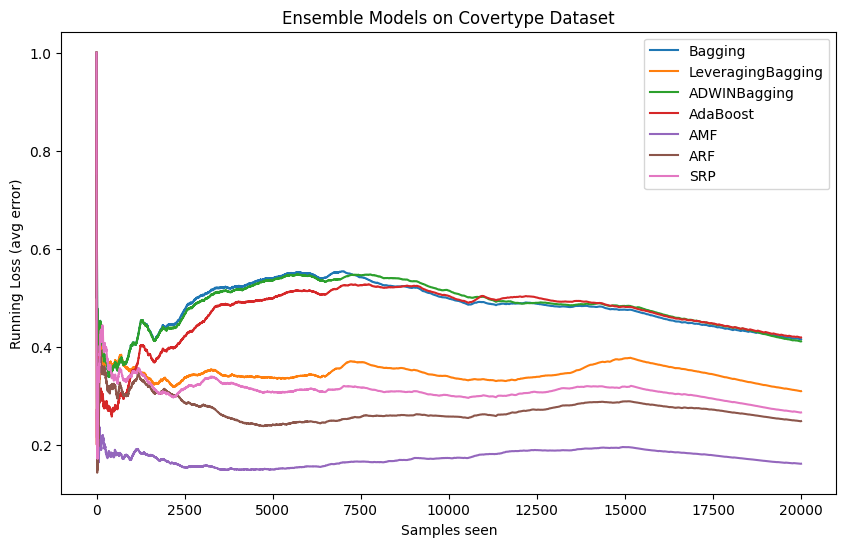

In [62]:
plt.figure(figsize=(10,6))
for name, res in results.items():
    plt.plot(res["running_losses"], label=name)

plt.xlabel("Samples seen")
plt.ylabel("Running Loss (avg error)")
plt.title("Ensemble Models on Covertype Dataset")
plt.legend()
plt.show()